In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from joblib import dump, load
import os

In [2]:
# pcafiles = [os.path.join("./saved_models/pca/", f) for f in os.listdir("./saved_models/pca/") if os.path.isfile(os.path.join("./saved_models/pca/", f))]

In [3]:
pca_times = load("./saved_models/pca/pca_times.joblib")
pca_memory = load("./saved_models/pca/pca_memory.joblib")
lgbm_pca_times = load("./saved_models/pca/lgbm_pca_times.joblib")
lgbm_pca_memory = load("./saved_models/pca/lgbm_pcs_memory.joblib")
pca_cv_scores = load("./saved_models/pca/cv_scores.joblib")
pca_fitted_models = load("./saved_models/pca/fitted_models.joblib")

lgbm_times = load("./saved_models/lgbm/lgbm_times.joblib")
lgbm_memory = load("./saved_models/lgbm/lgbm_memory.joblib")
lgbm_cv_scores = load("./saved_models/lgbm/cv_scores.joblib")
lgbm_fitted_models = load("./saved_models/lgbm/fitted_models.joblib")

fci_memory = load("./saved_models/fci/fci_memory.joblib")
fci_times = load("./saved_models/fci/fci_time.joblib")
direct_lgbm_fci_times = load("./saved_models/fci/direct_lbgm_fci_times.joblib")
direct_lgbm_fci_memory = load("./saved_models/fci/direct_lgbm_fci_memory.joblib")
direct_fitted_models = load("./saved_models/fci/direct_fitted_models.joblib")
direct_cv_scores = load("./saved_models/fci/direct_cv_scores.joblib")
generation_lgbm_fci_times = load("./saved_models/fci/1_more_generation_lbgm_fci_times.joblib")
generation_lgbm_fci_memory = load("./saved_models/fci/1_more_generation_lgbm_fci_memory.joblib")
generation_fitted_models = load("./saved_models/fci/1_more_generation_fitted_models.joblib")
generation_cv_scores = load("./saved_models/fci/1_more_generation_cv_scores.joblib")

In [4]:
best_ipcas = []
best_models = []
for i in range(0, 5):
    index = np.argmax(pca_cv_scores[i*5:i*5+5])
    best_ipcas.append(load(f"./saved_models/pca/{(5-i)*50}_n_components_{index}.joblib"))
    best_models.append(pca_fitted_models[i*5+index])
best_cv_pca = np.argmax(pca_cv_scores)

In [5]:
import sys
from pathlib import Path
import subprocess
import os
import gc
from glob import glob

import numpy as np
import pandas as pd
import polars as pl
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

ROOT = Path('/home/sabina.jangirova/Documents/ML703_project/data')

from sklearn.model_selection import TimeSeriesSplit, GroupKFold, StratifiedGroupKFold
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder

In [6]:
class Pipeline:

    def set_table_dtypes(df):
        for col in df.columns:
            if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.Int64))
            elif col in ["date_decision"]:
                df = df.with_columns(pl.col(col).cast(pl.Date))
            elif col[-1] in ("P", "A"):
                df = df.with_columns(pl.col(col).cast(pl.Float64))
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.String))
            elif col[-1] in ("D",):
                df = df.with_columns(pl.col(col).cast(pl.Date,strict=False))
        return df

    def handle_dates(df):
        for col in df.columns: 
                if col.endswith("D"):
                    # Calculate the difference in days between each date column and date_decision
                    df = df.with_columns(
                        (pl.col("date_decision") - pl.col(col)).dt.total_days().alias(col)
                    )
                    df = df.with_columns(pl.col(col).fill_null(np.nan)) 
        # Drop date_decision column
        df = df.drop("date_decision")
#         print(df.dtypes) # for Debugging
        return df

    def filter_cols(df,base_df = None,test=False):
        #for test data
            for col in df.columns:
                if col not in ["target", "case_id", "WEEK_NUM"]:
                    isnull = df[col].is_null().mean()
                    if isnull > 0.7:
                        df = df.drop(col)
            columns_to_drop = []
            for col in df.columns:
                if (col not in ["target", "case_id", "WEEK_NUM"]) & (df[col].dtype == pl.String):
                    freq = df[col].n_unique()
                    if (freq == 1) or (freq > 100):
                        columns_to_drop.append(col)

            df = df.drop(columns_to_drop)
            return df


class Aggregator:
    
    @staticmethod
    def num_expr(df):
        cols = [col for col in df.columns if col[-1] in ("P", "A")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        return expr_max

    @staticmethod
    def date_expr(df):
        cols = [col for col in df.columns if col[-1] in ("D",)]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        return expr_max

    @staticmethod
    def str_expr(df):
        cols = [col for col in df.columns if col[-1] in ("M",)]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        return expr_max

    @staticmethod
    def other_expr(df):
        cols = [col for col in df.columns if col[-1] in ("T", "L")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        return expr_max

    @staticmethod
    def count_expr(df):
        cols = [col for col in df.columns if "num_group" in col]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        return expr_max

    @staticmethod
    def get_exprs(df):
        exprs = Aggregator.num_expr(df) + \
                Aggregator.date_expr(df) + \
                Aggregator.str_expr(df) + \
                Aggregator.other_expr(df) + \
                Aggregator.count_expr(df)
        return exprs

def read_file(path, depth=None):
    df = pl.read_parquet(path)
    df = df.pipe(Pipeline.set_table_dtypes)
    if depth in [1,2]:
        df = df.group_by("case_id").agg(Aggregator.get_exprs(df)) 
    return df

def read_files(regex_path, depth=None):
    chunks = []
    for path in glob(str(regex_path)):
        df = pl.read_parquet(path)
        df = df.pipe(Pipeline.set_table_dtypes)
        if depth in [1, 2]:
            df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
        chunks.append(df)
    df = pl.concat(chunks, how="vertical_relaxed")
    df = df.unique(subset=["case_id"])
    return df

def feature_eng(df_base, depth_0, depth_1, depth_2):
    df_base = (
        df_base
        .with_columns(
            month_decision = pl.col("date_decision").dt.month(),
            weekday_decision = pl.col("date_decision").dt.weekday(),
        )
    )
    for i, df in enumerate(depth_0 + depth_1 + depth_2):
        df_base = df_base.join(df, how="left", on="case_id", suffix=f"_{i}")
    df_base = df_base.pipe(Pipeline.set_table_dtypes)
    df_base = df_base.pipe(Pipeline.handle_dates)
    return df_base

def to_pandas(df_data, cat_cols=None):
    df_data = df_data.to_pandas()
    if cat_cols is None:
        cat_cols = list(df_data.select_dtypes("object").columns)
    df_data[cat_cols] = df_data[cat_cols].astype("category")
    return df_data, cat_cols

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        if str(col_type)=="category":
            continue
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                try:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
                except:
                    continue
        else:
            continue
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [7]:
TRAIN_DIR       = ROOT / "parquet_files" / "train"
TEST_DIR        = ROOT / "parquet_files" / "test"

In [8]:
%%time
data_store = {
    "df_base": read_file(TRAIN_DIR / "train_base.parquet"),
    "depth_0": [
        read_file(TRAIN_DIR / "train_static_cb_0.parquet"),
        read_files(TRAIN_DIR / "train_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TRAIN_DIR / "train_applprev_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_a_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_c_1.parquet", 1),
        read_files(TRAIN_DIR / "train_credit_bureau_a_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_credit_bureau_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_other_1.parquet", 1),
        read_file(TRAIN_DIR / "train_person_1.parquet", 1),
        read_file(TRAIN_DIR / "train_deposit_1.parquet", 1),
        read_file(TRAIN_DIR / "train_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TRAIN_DIR / "train_credit_bureau_b_2.parquet", 2),
        read_files(TRAIN_DIR / "train_credit_bureau_a_2_*.parquet", 2),
        read_file(TRAIN_DIR / "train_applprev_2.parquet", 2),
        read_file(TRAIN_DIR / "train_person_2.parquet", 2)
    ]
}

CPU times: user 5min 26s, sys: 3min 16s, total: 8min 43s
Wall time: 5min


In [9]:
df = feature_eng(**data_store) # import train data 
print("train data shape:\t", df.shape)
# gc.collect()
# spamming gc.collect praying for memory to not full
gc.collect()
df = df.pipe(Pipeline.filter_cols) # fillter column
gc.collect()
df, cat_cols = to_pandas(df) # tranform to pandas dataframe, easier to work with
gc.collect()
df = reduce_mem_usage(df) # as the name said
gc.collect()
print("train data shape:\t", df.shape)
nums=df.select_dtypes(exclude='category').columns
# IDK what is going on for now
from itertools import combinations, permutations
#df=df[nums]
nans_df = df[nums].isna()
nans_groups={}
for col in nums:
    cur_group = nans_df[col].sum()
    try:
        nans_groups[cur_group].append(col)
    except:
        nans_groups[cur_group]=[col]
del nans_df; x=gc.collect()

def reduce_group(grps):
    use = []
    for g in grps:
        mx = 0; vx = g[0]
        for gg in g:
            n = df[gg].nunique()
            if n>mx:
                mx = n
                vx = gg
            #print(str(gg)+'-'+str(n),', ',end='')
        use.append(vx)
        #print()
    print('Use these',use)
    return use

def group_columns_by_correlation(matrix, threshold=0.8):
    correlation_matrix = matrix.corr()
    groups = []
    remaining_cols = list(matrix.columns)
    while remaining_cols:
        col = remaining_cols.pop(0)
        group = [col]
        correlated_cols = [col]
        for c in remaining_cols:
            if correlation_matrix.loc[col, c] >= threshold:
                group.append(c)
                correlated_cols.append(c)
        groups.append(group)
        remaining_cols = [c for c in remaining_cols if c not in correlated_cols]
    return groups

uses=[]
for k,v in nans_groups.items():
    if len(v)>1:
            Vs = nans_groups[k]
            #cross_features=list(combinations(Vs, 2))
            #make_corr(Vs)
            grps= group_columns_by_correlation(df[Vs], threshold=0.8)
            use=reduce_group(grps)
            uses=uses+use
            #make_corr(use)
    else:
        uses=uses+v
    print('####### NAN count =',k)
print(uses)
print(len(uses))
uses=uses+list(df.select_dtypes(include='category').columns)
print(len(uses))
df=df[uses]

train data shape:	 (1526659, 488)
Memory usage of dataframe is 3313.73 MB
Memory usage after optimization is: 1097.80 MB
Decreased by 66.9%
train data shape:	 (1526659, 344)
Use these ['case_id', 'WEEK_NUM', 'target', 'month_decision', 'weekday_decision', 'credamount_770A', 'applicationcnt_361L', 'applications30d_658L', 'applicationscnt_1086L', 'applicationscnt_464L', 'applicationscnt_867L', 'clientscnt_1022L', 'clientscnt_100L', 'clientscnt_1071L', 'clientscnt_1130L', 'clientscnt_157L', 'clientscnt_257L', 'clientscnt_304L', 'clientscnt_360L', 'clientscnt_493L', 'clientscnt_533L', 'clientscnt_887L', 'clientscnt_946L', 'deferredmnthsnum_166L', 'disbursedcredamount_1113A', 'downpmt_116A', 'homephncnt_628L', 'isbidproduct_1095L', 'mobilephncnt_593L', 'numactivecreds_622L', 'numactivecredschannel_414L', 'numactiverelcontr_750L', 'numcontrs3months_479L', 'numnotactivated_1143L', 'numpmtchanneldd_318L', 'numrejects9m_859L', 'sellerplacecnt_915L', 'max_mainoccupationinc_384A', 'max_birth_259D

In [10]:
y = df['target']
df = df.drop(columns=["case_id"])

In [11]:
df[cat_cols] = df[cat_cols].astype(str)
import polars as pl
from sklearn.preprocessing import OrdinalEncoder

# Fit Ordinal Encoder on Training Data
encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan)
encoder.fit(df[cat_cols])

# Transform Training Data
df[cat_cols] = encoder.transform(df[cat_cols])
df[cat_cols] = df[cat_cols].fillna(-1)
df[cat_cols] = df[cat_cols].astype(int)

In [12]:
df = df.fillna(0)

In [13]:
df = df.drop(columns=['target'])

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)

In [15]:
weeks = X_train['WEEK_NUM']
X_train = X_train.drop(columns=['WEEK_NUM'])
X_test = X_test.drop(columns=['WEEK_NUM'])

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_standardized = scaler.fit_transform(X_train)

In [17]:
# from sklearn.metrics import confusion_matrix, classification_report
# from sklearn.model_selection import StratifiedGroupKFold
# import numpy as np

# k = 0
# for ipca in best_ipcas:
#     conf_matrix = None
#     class_report = None
#     X_test_temp = scaler.transform(X_test)
#     X_test_temp = ipca.transform(X_test)

#     # Predict labels for validation data
#     y_pred_labels = best_models[k].predict(X_test_temp)

#     # Compute confusion matrix
#     conf_matrix = confusion_matrix(y_test, y_pred_labels)

#     # Compute classification report
#     class_report = classification_report(y_test, y_pred_labels)

#     # Print confusion matrix and classification report
#     print("Confusion Matrix:")
#     print(conf_matrix)
#     print("\nClassification Report:")
#     print(class_report)
    
#     k+=1

In [18]:
best_fci_models = []
for i in range(0, 4):
    index = np.argmax(direct_cv_scores[i*5:i*5+5])
    best_fci_models.append(direct_fitted_models[i*5+index])

In [19]:
direct_edges = [[6, 84, 168, 196], [129, 186, 238], [86, 200, 209], [36, 96, 179]]

In [20]:
best_fci_models

[LGBMClassifier(colsample_bynode=0.8, colsample_bytree=0.8, device_type='cpu',
                extra_trees=True, learning_rate=0.05, max_depth=10, metric='auc',
                n_estimators=2000, num_leaves=64, objective='binary',
                random_state=42, reg_alpha=0.1, reg_lambda=10, verbose=1),
 LGBMClassifier(colsample_bynode=0.8, colsample_bytree=0.8, device_type='cpu',
                extra_trees=True, learning_rate=0.05, max_depth=10, metric='auc',
                n_estimators=2000, num_leaves=64, objective='binary',
                random_state=42, reg_alpha=0.1, reg_lambda=10, verbose=1),
 LGBMClassifier(colsample_bynode=0.8, colsample_bytree=0.8, device_type='cpu',
                extra_trees=True, learning_rate=0.05, max_depth=10, metric='auc',
                n_estimators=2000, num_leaves=64, objective='binary',
                random_state=42, reg_alpha=0.1, reg_lambda=10, verbose=1),
 LGBMClassifier(colsample_bynode=0.8, colsample_bytree=0.8, device_type='cpu',
   

In [21]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedGroupKFold
import numpy as np

k = 0
for model in best_fci_models:
    conf_matrix = None
    class_report = None
    X_test_temp = scaler.transform(X_test)
    X_test_temp = best_ipcas[0].transform(X_test)
    X_test_temp = X_test_temp[:, direct_edges[k]]

    # Predict labels for validation data
    y_pred_labels = model.predict(X_test_temp)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_labels)

    # Compute classification report
    class_report = classification_report(y_test, y_pred_labels)

    # Print confusion matrix and classification report
    print("Confusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(class_report)
    
    k+=1

Confusion Matrix:
[[295779      0]
 [  9553      0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98    295779
           1       0.00      0.00      0.00      9553

    accuracy                           0.97    305332
   macro avg       0.48      0.50      0.49    305332
weighted avg       0.94      0.97      0.95    305332

Confusion Matrix:
[[295779      0]
 [  9553      0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98    295779
           1       0.00      0.00      0.00      9553

    accuracy                           0.97    305332
   macro avg       0.48      0.50      0.49    305332
weighted avg       0.94      0.97      0.95    305332

Confusion Matrix:
[[295779      0]
 [  9553      0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98    295779
      

In [22]:
best_fci_generation_models = []
for i in range(0, 4):
    index = np.argmax(generation_cv_scores[i*5:i*5+5])
    best_fci_generation_models.append(generation_fitted_models[i*5+index])

In [23]:
generation_edges = [['18', '160', '175', '85', '93', '123', '153', '24', '94', '46', '32', '63', '48', '223', '154', '124', '164', '88', '130', '161', '21', '92', '83', '68', '54', '16', '86', '217', '118', '169', '75', '7', '119', '65', '233', '27', '84', '29', '64', '41', '80', '226', '146', '158', '51', '126', '210', '38', '34', '36', '53', '69', '202', '163', '149', '56', '147', '8', '138', '159', '60', '155', '166', '26', '74', '199', '184', '44', '131', '66', '91', '15', '215', '109', '116', '71', '135', '50', '31', '206', '82', '134', '132', '6', '52', '113', '111', '20', '204', '100', '150', '106', '182', '76', '99', '167', '10', '142', '196', '61', '77', '62', '176', '186', '59', '55', '5', '221', '30', '96', '105', '139', '162', '23', '67', '79', '165', '58', '181', '103', '168'], ['186', '94', '55', '237', '124', '238', '27', '129', '118', '51', '4', '109', '218', '139'], ['40', '86', '209', '186', '94', '197', '9', '58', '200', '116'], ['40', '24', '135', '233', '196', '36', '179', '53', '166', '96', '2', '164', '160', '134', '136', '85']]
for l in range(len(generation_edges)):
    generation_edges[l] = [int(c) for c in generation_edges[l]]

In [24]:
k = 0
for model in best_fci_generation_models:
    conf_matrix = None
    class_report = None
    X_test_temp = scaler.transform(X_test)
    X_test_temp = best_ipcas[0].transform(X_test)
    X_test_temp = X_test_temp[:, generation_edges[k]]

    # Predict labels for validation data
    y_pred_labels = model.predict(X_test_temp)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_labels)

    # Compute classification report
    class_report = classification_report(y_test, y_pred_labels)

    # Print confusion matrix and classification report
    print("Confusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(class_report)
    
    k+=1

Confusion Matrix:
[[289286   6493]
 [  9243    310]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97    295779
           1       0.05      0.03      0.04      9553

    accuracy                           0.95    305332
   macro avg       0.51      0.51      0.51    305332
weighted avg       0.94      0.95      0.94    305332

Confusion Matrix:
[[295779      0]
 [  9553      0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98    295779
           1       0.00      0.00      0.00      9553

    accuracy                           0.97    305332
   macro avg       0.48      0.50      0.49    305332
weighted avg       0.94      0.97      0.95    305332

Confusion Matrix:
[[295779      0]
 [  9553      0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98    295779
      

In [25]:
lgbm_times = [-a for a in lgbm_times]
lgbm_memory = [-a for a in lgbm_memory]

training_pca_lgbm = []
for i in range(0, 5):
    training_pca_lgbm.append([])
    training_pca_lgbm[-1] = [-(a+b) for a, b in zip(pca_times[i*5:i*5+5], lgbm_pca_times[i*5:i*5+5])]

In [26]:
training_fci = []
for i in range(0, 4):
    training_fci.append([])
    training_fci[-1] = [-(pca_times[1] + a + fci_times[i]) for a in direct_lgbm_fci_times[i*5:i*5+5]]

In [27]:
training_fci

[[367.2837197780609,
  371.93253326416016,
  367.60261964797974,
  373.61109352111816,
  371.12209844589233],
 [262.3415939807892,
  255.7527482509613,
  258.6278405189514,
  257.4683475494385,
  260.9873719215393],
 [255.77029418945312,
  265.04601788520813,
  259.3596143722534,
  257.8833498954773,
  260.6678466796875],
 [193.8469798564911,
  193.9734230041504,
  195.76199769973755,
  194.88128638267517,
  192.6561243534088]]

In [28]:
training_pca_lgbm_memory = []
for i in range(0, 5):
    training_pca_lgbm_memory.append([])
    training_pca_lgbm_memory[-1] = [-(a+b) for a, b in zip(pca_memory[i*5:i*5+5], lgbm_pca_memory[i*5:i*5+5])]

In [29]:
training_fci_memory = []
for i in range(0, 4):
    training_fci_memory.append([])
    training_fci_memory[-1] = [-(pca_memory[1] + a + fci_memory[i]) for a in direct_lgbm_fci_memory[i*5:i*5+5]]

In [30]:
training_fci_generation_times = []
for i in range(0, 4):
    training_fci_generation_times.append([])
    training_fci_generation_times[-1] = [-(pca_times[1] + a + fci_times[i]) for a in generation_lgbm_fci_times[i*5:i*5+5]]

In [31]:
training_fci_generation_memory = []
for i in range(0, 4):
    training_fci_generation_memory.append([])
    training_fci_generation_memory[-1] = [-(pca_memory[1] + a + fci_memory[i]) for a in generation_lgbm_fci_memory[i*5:i*5+5]]

([<matplotlib.axis.XTick at 0x7f7a0dea5640>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

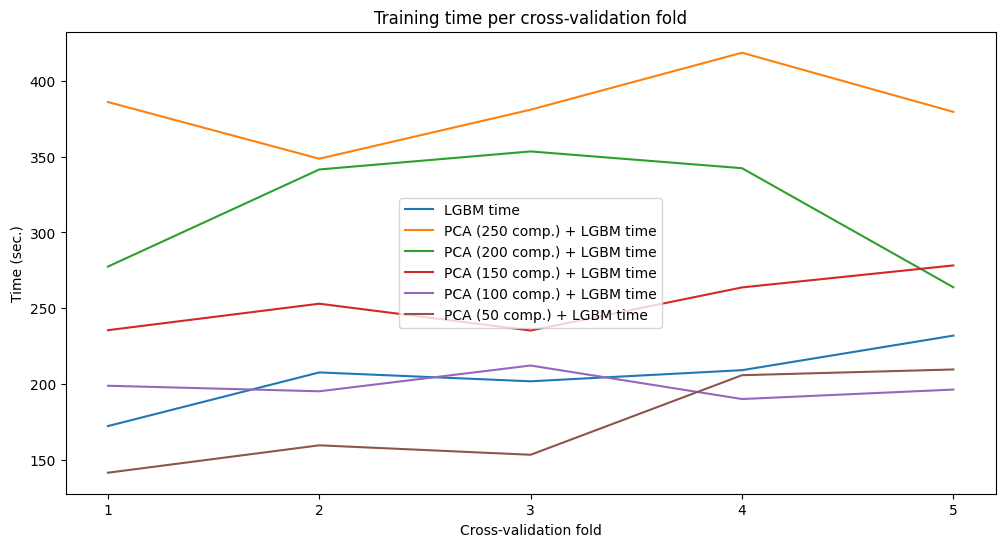

In [32]:
plt.figure(figsize=(12,6))
plt.plot(np.arange(1, 6), lgbm_times, label='LGBM time')
n = 250
for t in training_pca_lgbm:
    plt.plot(np.arange(1, 6), t, label=f'PCA ({n} comp.) + LGBM time')
    n -= 50

plt.title("Training time per cross-validation fold")
plt.ylabel("Time (sec.)")
plt.xlabel('Cross-validation fold')
plt.legend()
plt.xticks([1, 2, 3, 4, 5])

([<matplotlib.axis.XTick at 0x7f72c92813a0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

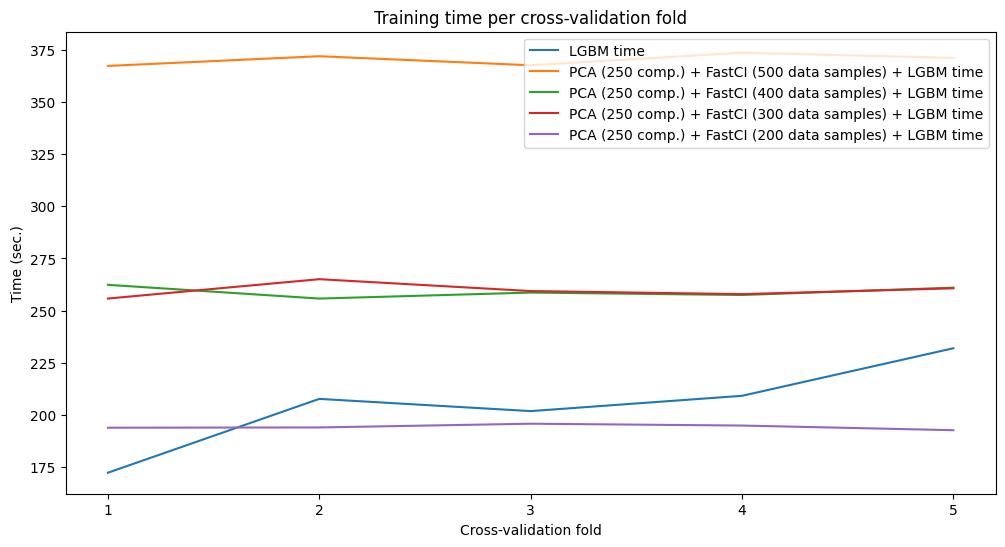

In [33]:
plt.figure(figsize=(12,6))
plt.plot(np.arange(1, 6), lgbm_times, label='LGBM time')
n = 500
for t in training_fci:
    plt.plot(np.arange(1, 6), t, label=f'PCA (250 comp.) + FastCI ({n} data samples) + LGBM time')
    n -= 100
plt.title("Training time per cross-validation fold")
plt.ylabel("Time (sec.)")
plt.xlabel('Cross-validation fold')
plt.legend()
plt.xticks([1, 2, 3, 4, 5])

([<matplotlib.axis.XTick at 0x7f727fa3a7f0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

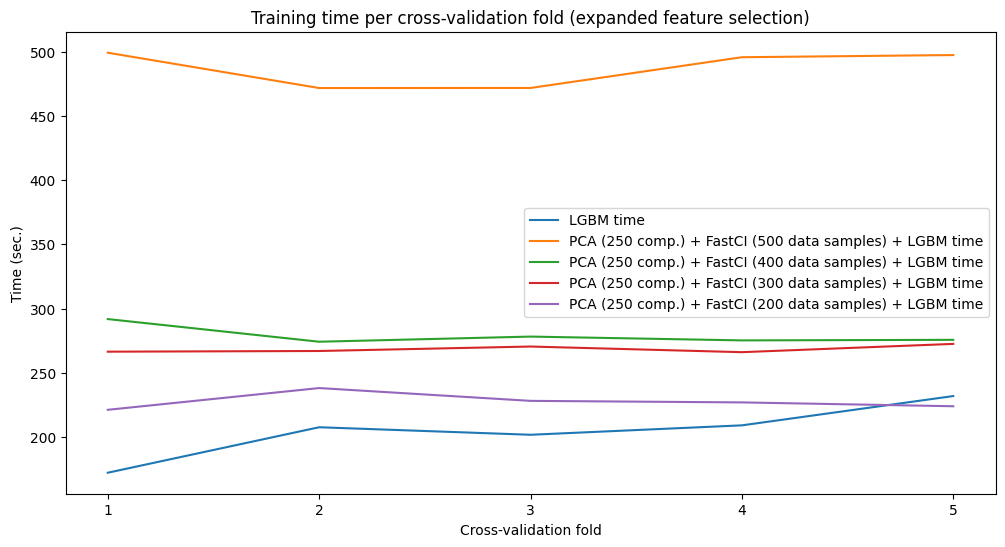

In [34]:
plt.figure(figsize=(12,6))
plt.plot(np.arange(1, 6), lgbm_times, label='LGBM time')
n = 500
for t in training_fci_generation_times:
    plt.plot(np.arange(1, 6), t, label=f'PCA (250 comp.) + FastCI ({n} data samples) + LGBM time')
    n -= 100
plt.title("Training time per cross-validation fold (expanded feature selection)")
plt.ylabel("Time (sec.)")
plt.xlabel('Cross-validation fold')
plt.legend()
plt.xticks([1, 2, 3, 4, 5])

In [35]:
# plt.figure(figsize=(12,6))
# plt.plot(np.arange(1, 6), lgbm_memory, label='LGBM time')
# print(lgbm_memory)
# n = 500
# for t in training_fci_generation_memory:
#     print(t)
#     plt.plot(np.arange(1, 6), t, label=f'PCA (250 comp.) + FastCI ({n} data samples) + LGBM time')
#     n -= 100
# plt.title("Training time per cross-validation fold")
# plt.ylabel("Time (sec.)")
# plt.xlabel('Cross-validation fold')
# plt.legend()
# plt.xticks([1, 2, 3, 4, 5])